# Lectura de Mediciones Transformadores

Notas:
1. Descargar de SITEC los archivos de Generacion de San Francisco
2. Graficar la Demanda x Trafos, la Generacion y la Suma
3. Graficar la tension en barra de 132 KV cuando entra la Generacion
4. Graficar la demanda en los trafos de Malvinas y relacionar

## Seteo Inicial

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Viernes 8 Octubre 2021 17:43:11 

@author: Daniel Busso
"""

# Plantilla de Pre Procesado

# Cómo importar las librerías
import numpy    as np
import pandas   as pd
import datetime as dt
import os

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import mean_absolute_percentage_error

#from skforecast.ForecasterAutoreg import ForecasterAutoreg
#from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
#from skforecast.model_selection import grid_search_forecaster
#from skforecast.model_selection import time_series_spliter
#from skforecast.model_selection import cv_forecaster
#from skforecast.model_selection import backtesting_forecaster
#from skforecast.model_selection import backtesting_forecaster_intervals

In [3]:
# Configuracion Pandas

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', '{:.2f}'.format)

In [4]:
def conversion_2400(fecha):
    if fecha[11:13] != '24':
        return pd.to_datetime(fecha, format='%d/%m/%Y %H:%M')

    fecha = fecha[0:11] + '00:' + fecha[14:]
    return pd.to_datetime(fecha, format='%d/%m/%Y %H:%M') + dt.timedelta(days=1)

## TG1

In [5]:
# EMPIEZO PROCESANDO UNA CARPETA
# AUTOMATIZAR LECTURAS DE VARIOS ARCHIVOS .PRN ANUALES
# lEER Y CONCATENAR LOS ARCHIVOS .prn DE LA CARPETA DSPractica/eetts/sanfrancisco/TD1

import os
import sys
from pathlib import Path

# ELEGIR PLATAFORMA WINDOWS LOCAL O GOOGLE COLABORATORY
if sys.platform == 'linux' :
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  carpeta_trabajo = Path('/content/drive/Othercomputers/LENOVO/DSPractica/eetts/san_francisco/TG1') # Google Colab
else:
  carpeta_inicio  = Path.home()
  carpeta_eett = Path("DSPractica/eetts/san_francisco/TG1")
  carpeta_trabajo = carpeta_inicio / carpeta_eett

archivos = list(carpeta_trabajo.glob('*.prn'))

# Automatizacion de los DataFrames 
i = 0
for nombre_completo in archivos:
    if (i == 0) :
        dfconca = pd.read_fwf(nombre_completo, header=0, decimal=',')
    else:
        dfdatos = pd.read_fwf(nombre_completo, header=0, decimal=',')
        dfconca = pd.concat([dfconca, dfdatos], ignore_index=True)
    i = i + 1
    
# BORRAMOS COLUMNAS NO USADAS
dfconca = dfconca.drop(columns=['Ampere', 'KVolt'])
dfconca

,Fecha,Hora,MW,MVAR,MVA
0,01/01/2011,00:15,11.22,2.39,11.47
1,01/01/2011,00:30,0.00,0.06,0.06
2,01/01/2011,00:45,0.00,0.07,0.07
3,01/01/2011,01:00,0.00,0.07,0.07
4,01/01/2011,01:15,0.00,0.07,0.07
...,...,...,...,...,...
632194,31/12/2020,23:40,0.00,0.07,0.07
632195,31/12/2020,23:45,0.00,0.07,0.07
632196,31/12/2020,23:50,0.00,0.07,0.07
632197,31/12/2020,23:55,0.00,0.07,0.07


In [6]:
# GENERAMOS INDICE DE FECHAS PARA MANEJAR LA SERIE DE TIEMPO
# Lectura y creacion del index DateTime para tratar el DataFrame como una Serie de Tiempo

dfconca['Fecha_Hora'] = dfconca['Fecha'] + ' ' + dfconca['Hora']
dfconca['Fecha_Hora'] = dfconca.Fecha_Hora.apply(conversion_2400) # CONVERSION DE HORA 24:00 ---> 00:00

dfconca.set_index('Fecha_Hora', inplace=True)
serie     = dfconca.drop(dfconca.index[-1]) # borro la fila del nuevo anio
serie_ord = serie.sort_index()
TG1 = serie_ord.copy()

# BORRAMOS Columnas Fecha Hora porque ya tenemos el Index Temporal
TG1 = TG1.drop(columns=['Fecha', 'Hora'])

# Renombramos Columnas
TG1.columns = ['TG1_MW', 'TG1_MVAR', 'TG1_MVA']

# VERIFICAR Y REMOVER DUPLICADOS

if TG1.index.has_duplicates:
    print('SI TIENE DUPLICADOS')
else:
    print('NO TIENE DUPLICADOS')
    
TG1

NO TIENE DUPLICADOS


,TG1_MW,TG1_MVAR,TG1_MVA
Fecha_Hora,,,
2011-01-01 00:15:00,11.22,2.39,11.47
2011-01-01 00:30:00,0.00,0.06,0.06
2011-01-01 00:45:00,0.00,0.07,0.07
2011-01-01 01:00:00,0.00,0.07,0.07
2011-01-01 01:15:00,0.00,0.07,0.07
...,...,...,...
2020-12-31 23:35:00,0.00,0.08,0.08
2020-12-31 23:40:00,0.00,0.07,0.07
2020-12-31 23:45:00,0.00,0.07,0.07


### TG1 Remover Atipicos

In [7]:
# CALCULO FORMAL DE LOS LIMITES SUPERIOR E INFERIOR

Pot_Instalada = pd.Series([20.0, 28.0], index=['TG1', 'TG2'])  # con cos fi = 0.8 TG1 = 16 MW y TG2 = 23 MW 
POT_INSTALADA = Pot_Instalada.sum()

q75, q25 = TG1['TG1_MVA'].quantile(0.75), TG1['TG1_MVA'].quantile(0.25)
IQR = q75 - q25
bigote = 3 * IQR
lim_sup, lim_inf = q75 + bigote, q25 - bigote
if lim_inf < 0 :
    lim_inf = 0.0

    
# PODRIA USAR DIRECTAMENTE COMO LIMITES
lim_sup = Pot_Instalada.TG1
lim_inf = 0

In [8]:
# IDENTIFICAR ATIPICOS
TG1_atipicos = TG1[(TG1['TG1_MVA'] < lim_inf) | (TG1['TG1_MVA'] > lim_sup)]
print('Atipicos identificados: %d' % len(TG1_atipicos))

# REMOVER ATIPICOS
TG1_sin_atipicos = TG1[(TG1['TG1_MVA'] >= lim_inf) & (TG1['TG1_MVA'] <= lim_sup)]
print('TG1_MVA sin Atipicos: %d' % len(TG1_sin_atipicos))

Atipicos identificados: 25
TG1_MVA sin Atipicos: 632173


In [9]:
TG1_sin_atipicos

,TG1_MW,TG1_MVAR,TG1_MVA
Fecha_Hora,,,
2011-01-01 00:15:00,11.22,2.39,11.47
2011-01-01 00:30:00,0.00,0.06,0.06
2011-01-01 00:45:00,0.00,0.07,0.07
2011-01-01 01:00:00,0.00,0.07,0.07
2011-01-01 01:15:00,0.00,0.07,0.07
...,...,...,...
2020-12-31 23:35:00,0.00,0.08,0.08
2020-12-31 23:40:00,0.00,0.07,0.07
2020-12-31 23:45:00,0.00,0.07,0.07


## TG2

In [10]:
# EMPIEZO PROCESANDO UNA CARPETA
# AUTOMATIZAR LECTURAS DE VARIOS ARCHIVOS .PRN ANUALES
# lEER Y CONCATENAR LOS ARCHIVOS .prn DE LA CARPETA DSPractica/eetts/sanfrancisco/TG2

import os
import sys
from pathlib import Path

# ELEGIR PLATAFORMA WINDOWS LOCAL O GOOGLE COLABORATORY
if sys.platform == 'linux' :
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  carpeta_trabajo = Path('/content/drive/Othercomputers/LENOVO/DSPractica/eetts/san_francisco/TG2') # Google Colab
else:
  carpeta_inicio  = Path.home()
  carpeta_eett = Path("DSPractica/eetts/san_francisco/TG2")
  carpeta_trabajo = carpeta_inicio / carpeta_eett

archivos = list(carpeta_trabajo.glob('*.prn'))

# Automatizacion de los DataFrames 
i = 0
for nombre_completo in archivos:
    if (i == 0) :
        dfconca = pd.read_fwf(nombre_completo, header=0, decimal=',')
    else:
        dfdatos = pd.read_fwf(nombre_completo, header=0, decimal=',')
        dfconca = pd.concat([dfconca, dfdatos], ignore_index=True)
    i = i + 1
    
# BORRAMOS COLUMNAS NO USADAS
dfconca = dfconca.drop(columns=['Ampere', 'KVolt'])
dfconca

,Fecha,Hora,MW,MVAR,MVA
0,01/01/2011,00:15,0.00,0.06,0.06
1,01/01/2011,00:30,0.00,0.06,0.06
2,01/01/2011,00:45,0.00,0.06,0.06
3,01/01/2011,01:00,0.00,0.06,0.06
4,01/01/2011,01:15,0.00,0.06,0.06
...,...,...,...,...,...
632202,31/12/2020,23:40,0.00,0.09,0.09
632203,31/12/2020,23:45,0.00,0.09,0.09
632204,31/12/2020,23:50,0.00,0.08,0.08
632205,31/12/2020,23:55,0.00,0.09,0.09


In [11]:
# GENERAMOS INDICE DE FECHAS PARA MANEJAR LA SERIE DE TIEMPO
# Lectura y creacion del index DateTime para tratar el DataFrame como una Serie de Tiempo

dfconca['Fecha_Hora'] = dfconca['Fecha'] + ' ' + dfconca['Hora']
dfconca['Fecha_Hora'] = dfconca.Fecha_Hora.apply(conversion_2400) # CONVERSION DE HORA 24:00 ---> 00:00

dfconca.set_index('Fecha_Hora', inplace=True)
serie     = dfconca.drop(dfconca.index[-1]) # borro la fila del nuevo anio
serie_ord = serie.sort_index()
TG2 = serie_ord.copy()

# BORRAMOS Columnas Fecha Hora porque ya tenemos el Index Temporal
TG2 = TG2.drop(columns=['Fecha', 'Hora'])

# Renombramos Columnas
TG2.columns = ['TG2_MW', 'TG2_MVAR', 'TG2_MVA']

# VERIFICAR Y REMOVER DUPLICADOS

if TG2.index.has_duplicates:
    print('SI TIENE DUPLICADOS')
else:
    print('NO TIENE DUPLICADOS')
    
TG2

NO TIENE DUPLICADOS


,TG2_MW,TG2_MVAR,TG2_MVA
Fecha_Hora,,,
2011-01-01 00:15:00,0.00,0.06,0.06
2011-01-01 00:30:00,0.00,0.06,0.06
2011-01-01 00:45:00,0.00,0.06,0.06
2011-01-01 01:00:00,0.00,0.06,0.06
2011-01-01 01:15:00,0.00,0.06,0.06
...,...,...,...
2020-12-31 23:35:00,0.00,0.10,0.10
2020-12-31 23:40:00,0.00,0.09,0.09
2020-12-31 23:45:00,0.00,0.09,0.09


### TG2 Remover Atipicos

In [43]:
# CALCULO FORMAL DE LOS LIMITES SUPERIOR E INFERIOR

q75, q25 = TG2['TG2_MVA'].quantile(0.75), TG2['TG2_MVA'].quantile(0.25)
IQR = q75 - q25
bigote = 3 * IQR
lim_sup, lim_inf = q75 + bigote, q25 - bigote
if lim_inf < 0 :
    lim_inf = 0.0

    
# PODRIA USAR DIRECTAMENTE COMO LIMITES
lim_sup = Pot_Instalada.TG2
lim_inf = 0

In [45]:
# IDENTIFICAR ATIPICOS
TG2_atipicos = TG2[(TG2['TG2_MVA'] < lim_inf) | (TG2['TG2_MVA'] > lim_sup)]
print('Atipicos identificados: %d' % len(TG2_atipicos))


# REMOVER ATIPICOS
TG2_sin_atipicos = TG2[(TG2['TG2_MVA'] >= lim_inf) & (TG2['TG2_MVA'] <= lim_sup)]
print('TG2_MVA sin Atipicos: %d' % len(TG2_sin_atipicos))

Atipicos identificados: 27
TG2_MVA sin Atipicos: 632179


In [46]:
TG2_sin_atipicos

,TG2_MW,TG2_MVAR,TG2_MVA
Fecha_Hora,,,
2011-01-01 00:15:00,0.00,0.06,0.06
2011-01-01 00:30:00,0.00,0.06,0.06
2011-01-01 00:45:00,0.00,0.06,0.06
2011-01-01 01:00:00,0.00,0.06,0.06
2011-01-01 01:15:00,0.00,0.06,0.06
...,...,...,...
2020-12-31 23:35:00,0.00,0.10,0.10
2020-12-31 23:40:00,0.00,0.09,0.09
2020-12-31 23:45:00,0.00,0.09,0.09


# Concatenar TG1 + TG2 para despues sumar 

In [47]:
# CONCATENAR TD1 + TD2 + TD3
#
Gene = pd.concat([TG1_sin_atipicos, TG2_sin_atipicos], axis = 1)

# Reemplazar np.nan con ceros
Gene = Gene.replace(np.nan,0)

# Suma Potencia Aparente
Gene['Suma'] = Gene['TG1_MVA'] + Gene['TG2_MVA']

Gene

,TG1_MW,TG1_MVAR,TG1_MVA,TG2_MW,TG2_MVAR,TG2_MVA,Suma
Fecha_Hora,,,,,,,
2011-01-01 00:15:00,11.22,2.39,11.47,0.00,0.06,0.06,11.53
2011-01-01 00:30:00,0.00,0.06,0.06,0.00,0.06,0.06,0.12
2011-01-01 00:45:00,0.00,0.07,0.07,0.00,0.06,0.06,0.13
2011-01-01 01:00:00,0.00,0.07,0.07,0.00,0.06,0.06,0.13
2011-01-01 01:15:00,0.00,0.07,0.07,0.00,0.06,0.06,0.13
...,...,...,...,...,...,...,...
2020-12-31 23:35:00,0.00,0.08,0.08,0.00,0.10,0.10,0.18
2020-12-31 23:40:00,0.00,0.07,0.07,0.00,0.09,0.09,0.16
2020-12-31 23:45:00,0.00,0.07,0.07,0.00,0.09,0.09,0.16


### Boxplot o Diagrama de Caja de Pot Aparente

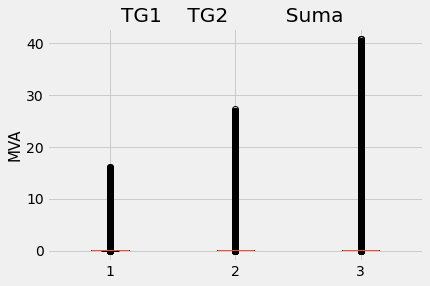

In [48]:

#plt.boxplot(Trafos['TD1_MVA', 'TD2_MVA', 'TD3_MVA', 'Suma'])

data = Gene[['TG1_MVA', 'TG2_MVA', 'Suma']]
fig1, ax1 = plt.subplots()
ax1.set_title('TG1    TG2         Suma ')
ax1.set_ylabel("MVA", fontsize=15)  # Add a y-label to the axes.
ax1.boxplot(data)

plt.show()

In [49]:
#
# Grafica del Pico Maximo Potencia Aparente x DIA

def Grafica_xDia_Mensual(pi, pf):
    plt.style.use('fivethirtyeight')
    
    #y = datos.loc[anio:anio, 'MVA'].resample('D').max()
    #x = y.index
    
    gg = Gene.loc[pi:pf, ['TG1_MVA', 'TG2_MVA', 'Suma']]
    

    x = gg['TG1_MVA']
    y = gg['TG2_MVA']
    
    s = gg['Suma']
    t = x.index 
    
    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(30, 5))
    
    #grafico.plot(x, y, lw=1, label='Potencia Aparente', marker='o')
    grafico.plot(t, x, lw=1, label='TG1', marker='o', color='g')
    grafico.plot(t, y, lw=1, label='TG2', marker='o', color='y')
    
    grafico.plot(t, s, lw=2, label='TG1+TG2', marker='o', color='k')
    
    grafico.set_xlabel('[ Meses ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("POTENCIA APARENTE DIARIA " + pi + pf)  # Add a title to the axes.
    grafico.legend()  # Add a legend.
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid()
    
    #fig.savefig("Serie_Anual_xDia_"+anio+".png")

<Figure size 432x288 with 0 Axes>

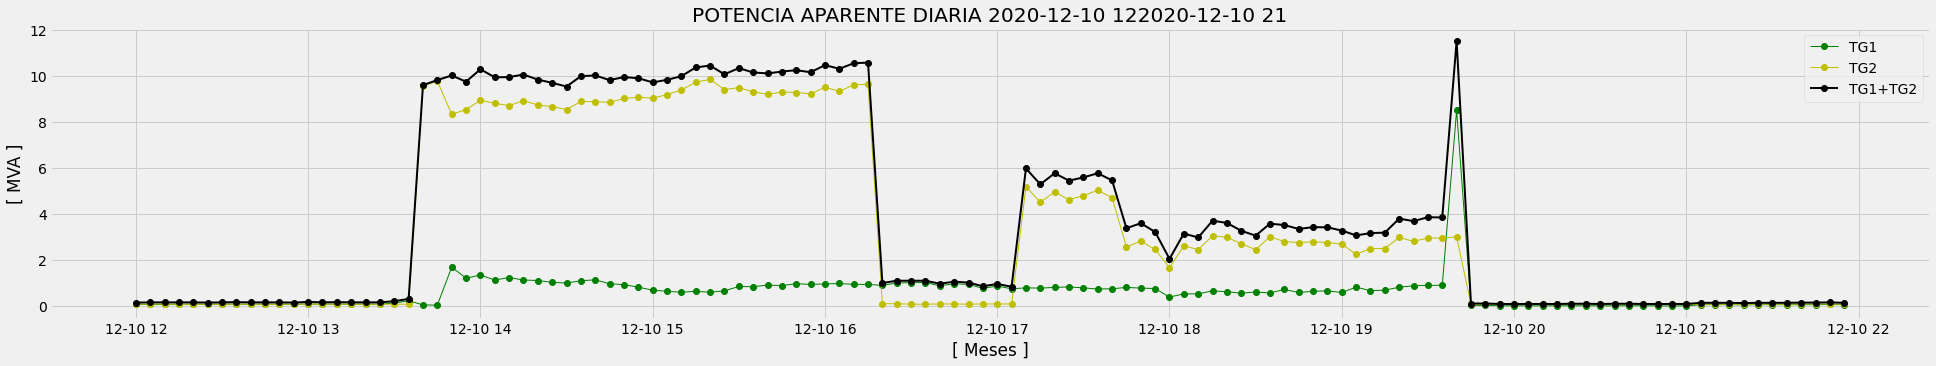

In [50]:
Grafica_xDia_Mensual('2020-12-10 12', '2020-12-10 21')

<Figure size 432x288 with 0 Axes>

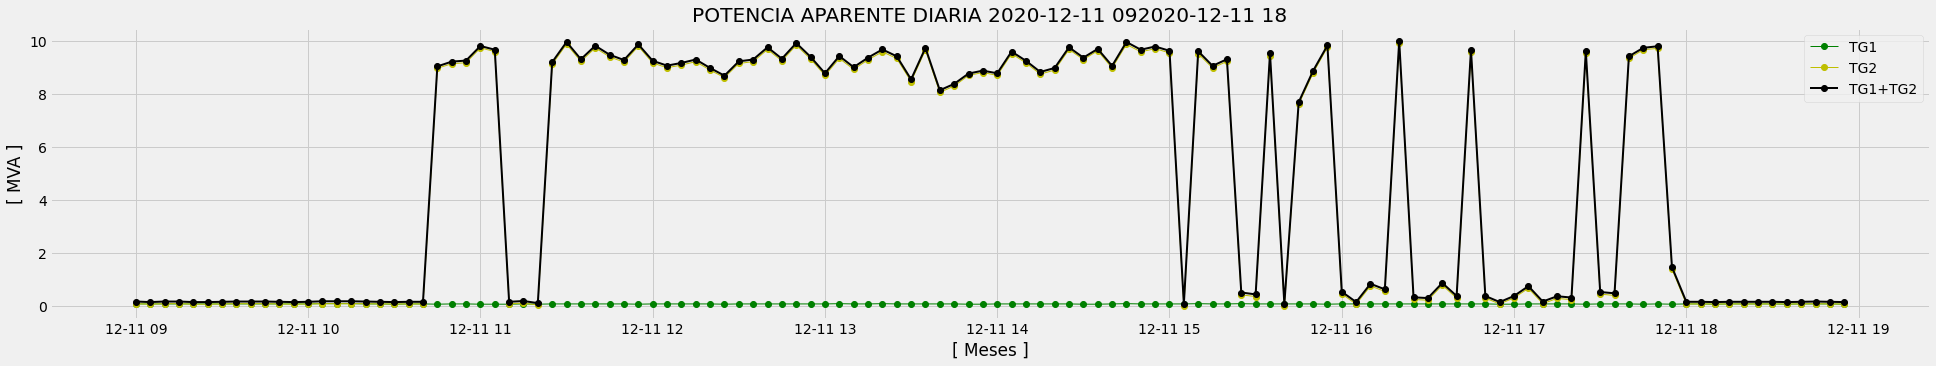

In [20]:
Grafica_xDia_Mensual('2020-12-11 09', '2020-12-11 18')

<Figure size 432x288 with 0 Axes>

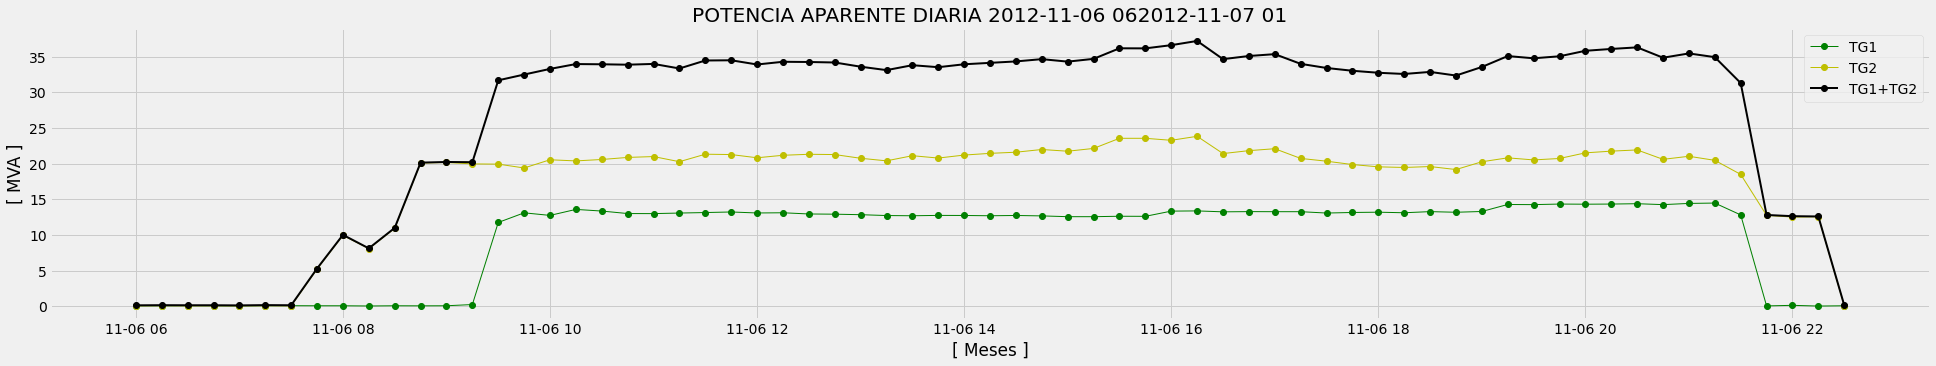

In [53]:
Grafica_xDia_Mensual('2012-11-06 06', '2012-11-07 01')

<Figure size 432x288 with 0 Axes>

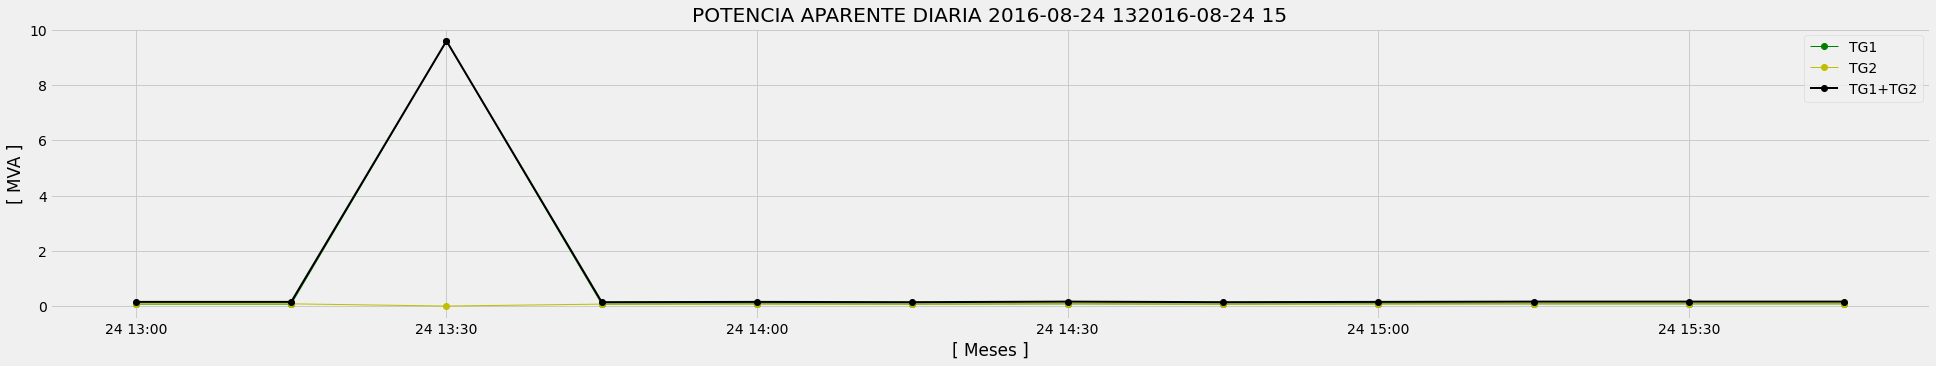

In [54]:
Grafica_xDia_Mensual('2016-08-24 13', '2016-08-24 15')

# Valores Maximos de Suma x Dia 

In [55]:
#
# Generar Pot_max_xdia para todos los anios

# Obtengo los Valores Maximos x Dia  ---- No puedo utilizar resample('D') porque me da los valores Maximos para todas las columnas
# y yo necesito los valores MVA para los cuales Suma es maxima en el Dia

Pot_max_xdia = pd.DataFrame(columns = ['TG1_MVA', 'TG2_MVA', 'Suma'])

#anios = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
anio_ini = '2011'
anio_fin = '2020'
pi = anio_ini + '-01-01'
pf = anio_fin + '-12-31'

dias = pd.date_range(start=pi, end=pf, freq='D')
for dia in dias:
    dia = dia.strftime('%Y/%m/%d')
    if Gene.loc[dia, :].empty :
        pass
    else:
        ind = Gene.loc[dia, 'Suma'].idxmax()
        Pot_max_xdia.loc[ind] = Gene.loc[ind, ['TG1_MVA', 'TG2_MVA', 'Suma']] 

Pot_max_xdia

,TG1_MVA,TG2_MVA,Suma
2011-01-01 22:15:00,12.88,0.06,12.94
2011-01-02 23:30:00,13.68,0.06,13.74
2011-01-03 09:30:00,12.65,0.07,12.72
2011-01-04 09:45:00,13.84,0.06,13.90
2011-01-05 22:45:00,15.02,0.07,15.09
...,...,...,...
2020-12-26 10:30:00,0.09,0.09,0.18
2020-12-28 08:00:00,0.08,0.10,0.18
2020-12-29 17:00:00,0.09,0.09,0.18
2020-12-30 17:25:00,0.08,0.10,0.18


## Verifico Dias que faltan en Pot_max_xdia

In [56]:
# CHEQUEA EL INDICE POR DIAS FALTANTES 
# SI FALTA UN DIA: AGREGA LA FILA CON VALORES NAN

pi = Pot_max_xdia.index[0]
pi = pi.strftime('%Y/%m/%d')
pf = Pot_max_xdia.index[-1]
pf = pf.strftime('%Y/%m/%d')
 
ind_ok = pd.date_range(start=pi, end=pf, freq="D")
ind_ck = Pot_max_xdia.index.date

dife = ind_ok.difference(ind_ck)

for ind in dife.values:
    Pot_max_xdia.loc[ind] = np.nan, np.nan, np.nan
    
Pot_max_xdia_nan = Pot_max_xdia.sort_index()
Pot_max_xdia_ori = Pot_max_xdia_nan.copy()

Pot_max_xdia_nan

,TG1_MVA,TG2_MVA,Suma
2011-01-01 22:15:00,12.88,0.06,12.94
2011-01-02 23:30:00,13.68,0.06,13.74
2011-01-03 09:30:00,12.65,0.07,12.72
2011-01-04 09:45:00,13.84,0.06,13.90
2011-01-05 22:45:00,15.02,0.07,15.09
...,...,...,...
2020-12-27 00:00:00,NaN,NaN,NaN
2020-12-28 08:00:00,0.08,0.10,0.18
2020-12-29 17:00:00,0.09,0.09,0.18
2020-12-30 17:25:00,0.08,0.10,0.18


In [57]:
dife

DatetimeIndex(['2020-12-27'], dtype='datetime64[ns]', freq=None)

## Interpolacion de Pot_max_xdia

In [58]:
#  INTERPOLAR LOS DIAS FALTANTES

Pot_max_xdia = Pot_max_xdia_nan.interpolate()

In [59]:
# Grafica del Pico Maximo Potencia Aparente x DIA

def Grafica_xDia(pi, pf):
    plt.style.use('fivethirtyeight')
        
    #pi = anio + '-07-01'
    #pf = anio + '-07-31'
    
    x = Pot_max_xdia.loc[pi:pf, 'TG1_MVA']
    y = Pot_max_xdia.loc[pi:pf, 'TG2_MVA']
    
    s = Pot_max_xdia.loc[pi:pf, 'Suma']
    t = x.index 
    
    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(30, 5))
    
    #grafico.plot(x, y, lw=1, label='Potencia Aparente', marker='o')
    grafico.plot(t, x, lw=1, label='TG1', marker='o', color='g')
    grafico.plot(t, y, lw=1, label='TG2', marker='o', color='y')
    
    grafico.plot(t, s, lw=2, label='TG1+TG2', marker='o', color='k')
    
    grafico.set_xlabel('[ Meses ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("POTENCIA APARENTE DIARIA " + pi + pf)  # Add a title to the axes.
    grafico.legend()  # Add a legend.
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid()
    
    #fig.savefig("Serie_Anual_xDia_"+anio+".png")

<Figure size 432x288 with 0 Axes>

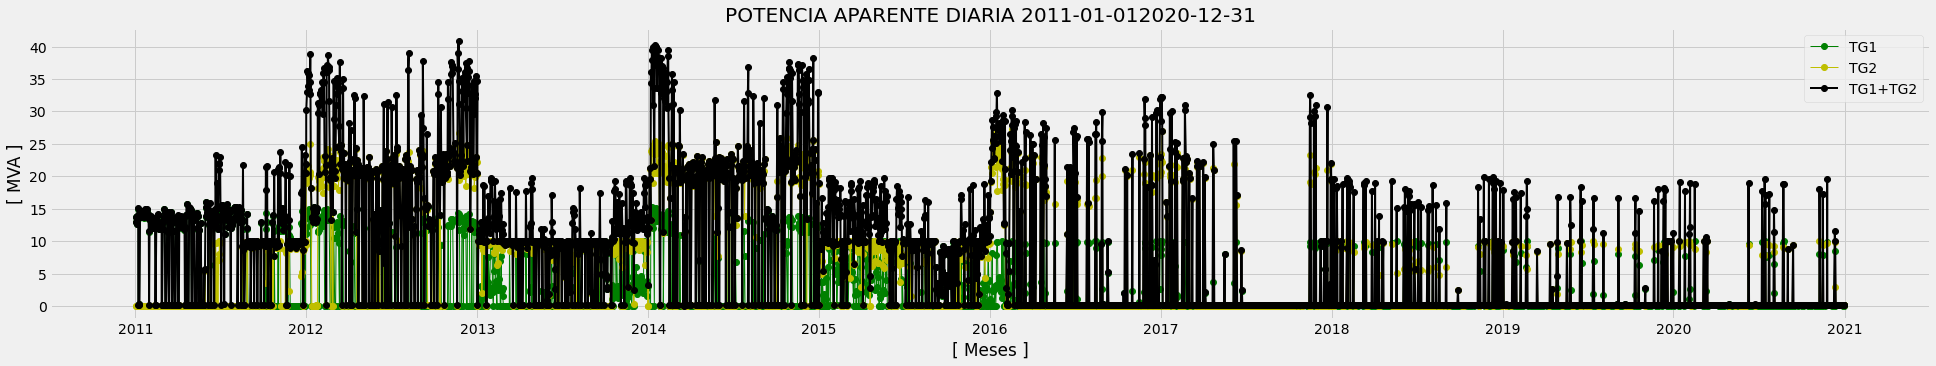

In [86]:
Grafica_xDia('2011-01-01', '2020-12-31')

<Figure size 432x288 with 0 Axes>

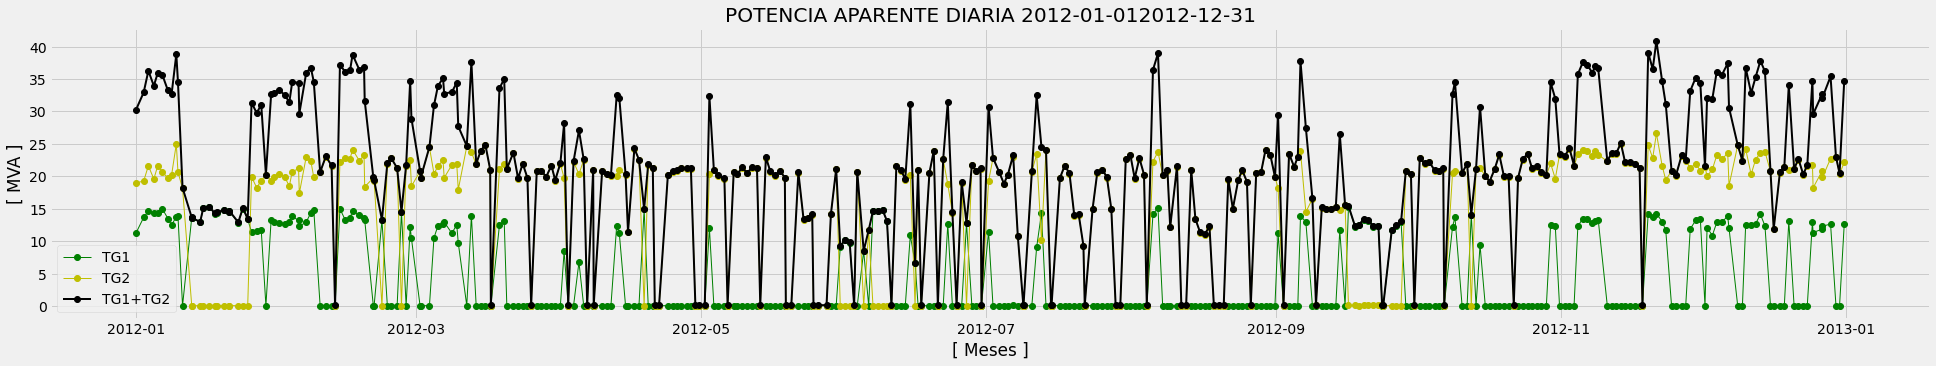

In [87]:
Grafica_xDia('2012-01-01', '2012-12-31')

<Figure size 432x288 with 0 Axes>

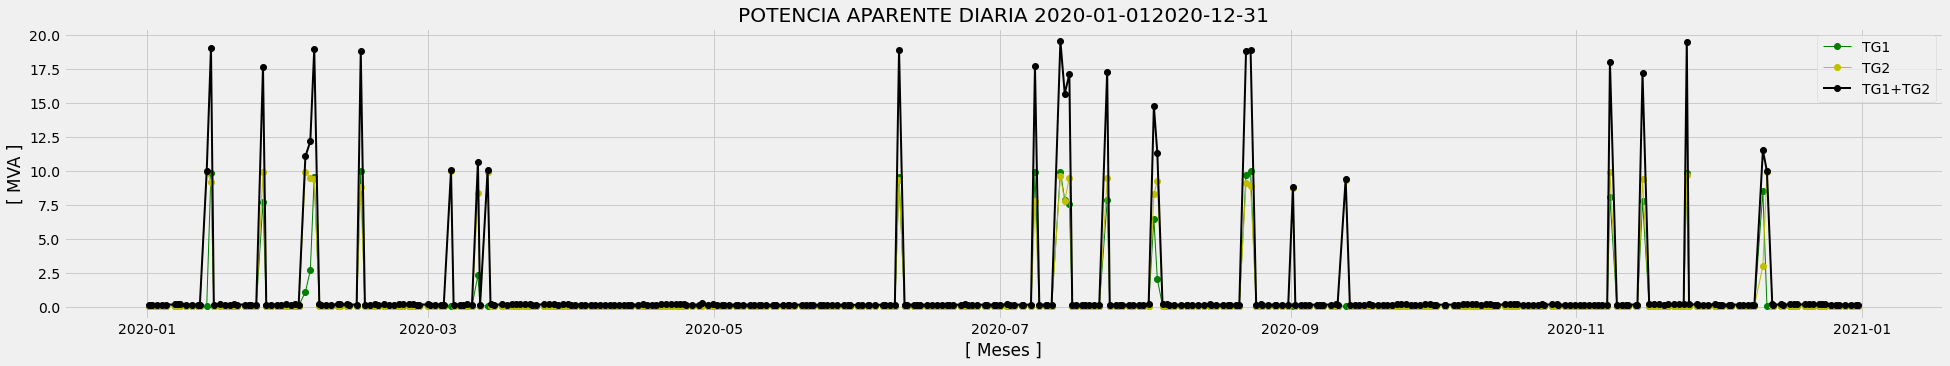

In [73]:
Grafica_xDia('2020-01-01', '2020-12-31')

<Figure size 432x288 with 0 Axes>

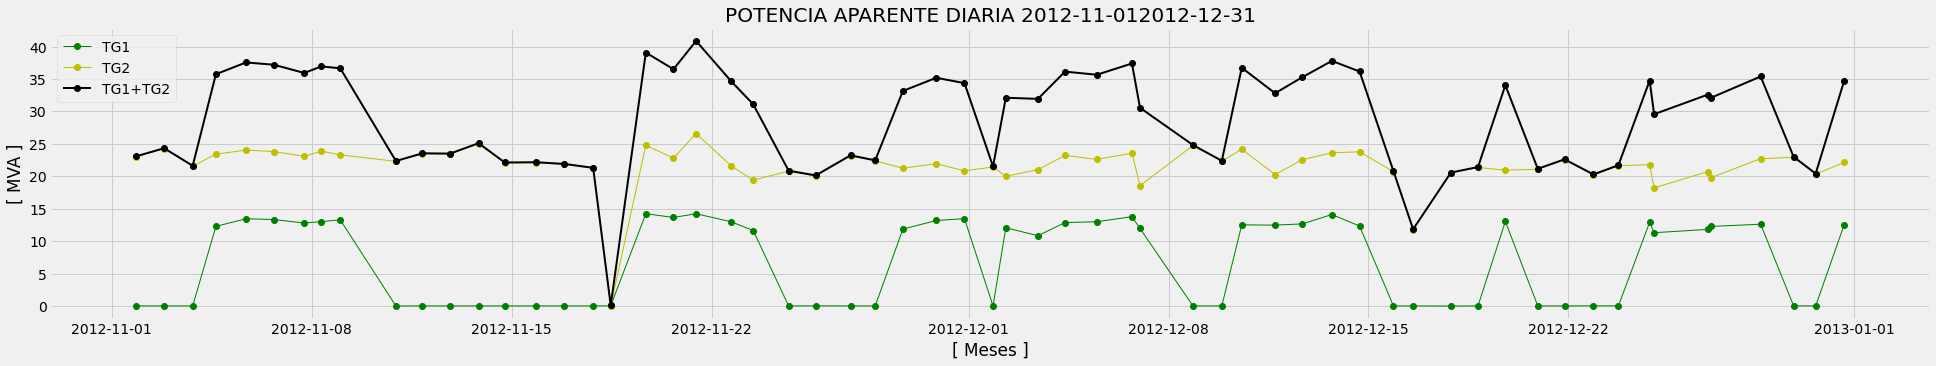

In [88]:
Grafica_xDia('2012-11-01', '2012-12-31')

<Figure size 432x288 with 0 Axes>

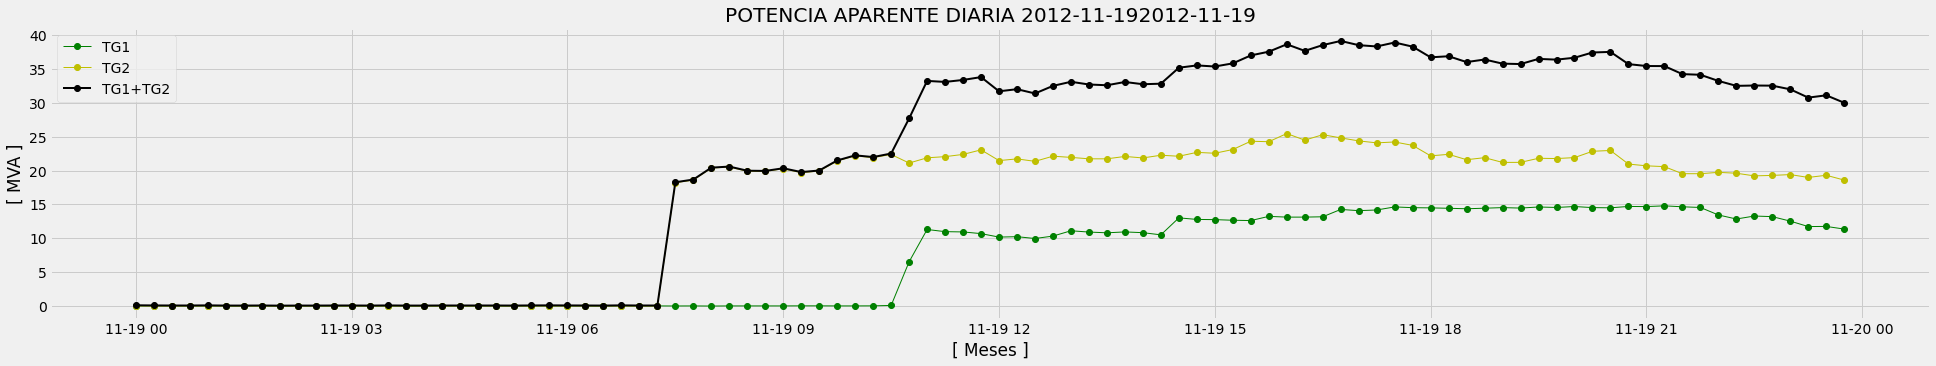

In [91]:
Grafica_xDia_Mensual('2012-11-19', '2012-11-19')

<Figure size 432x288 with 0 Axes>

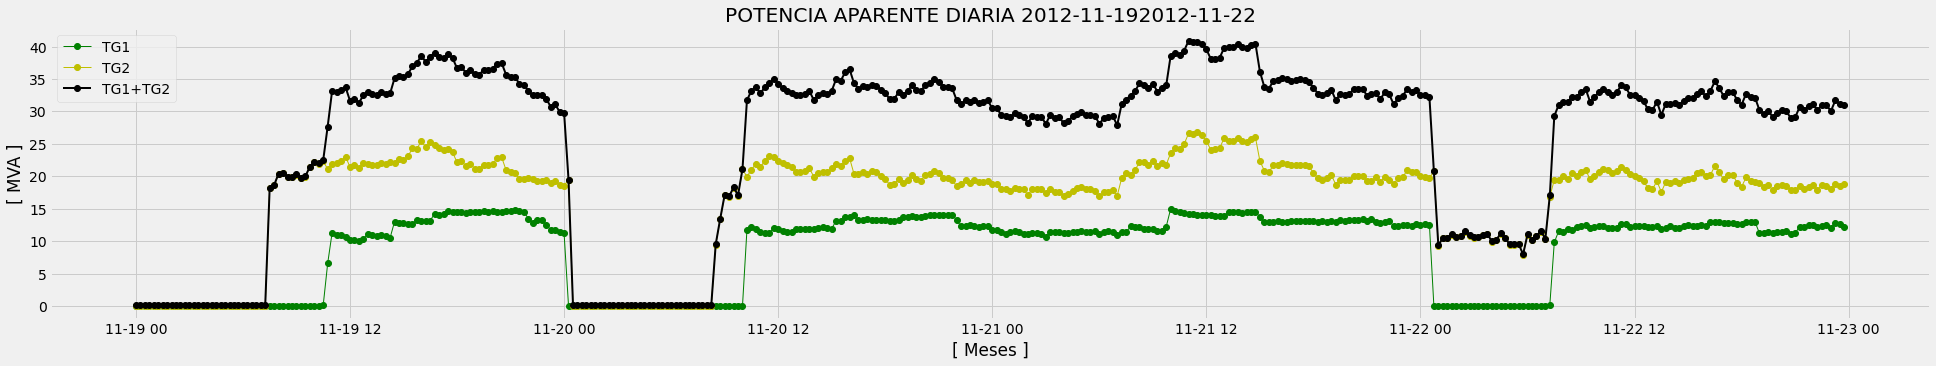

In [94]:
Grafica_xDia_Mensual('2012-11-19', '2012-11-22')

<Figure size 432x288 with 0 Axes>

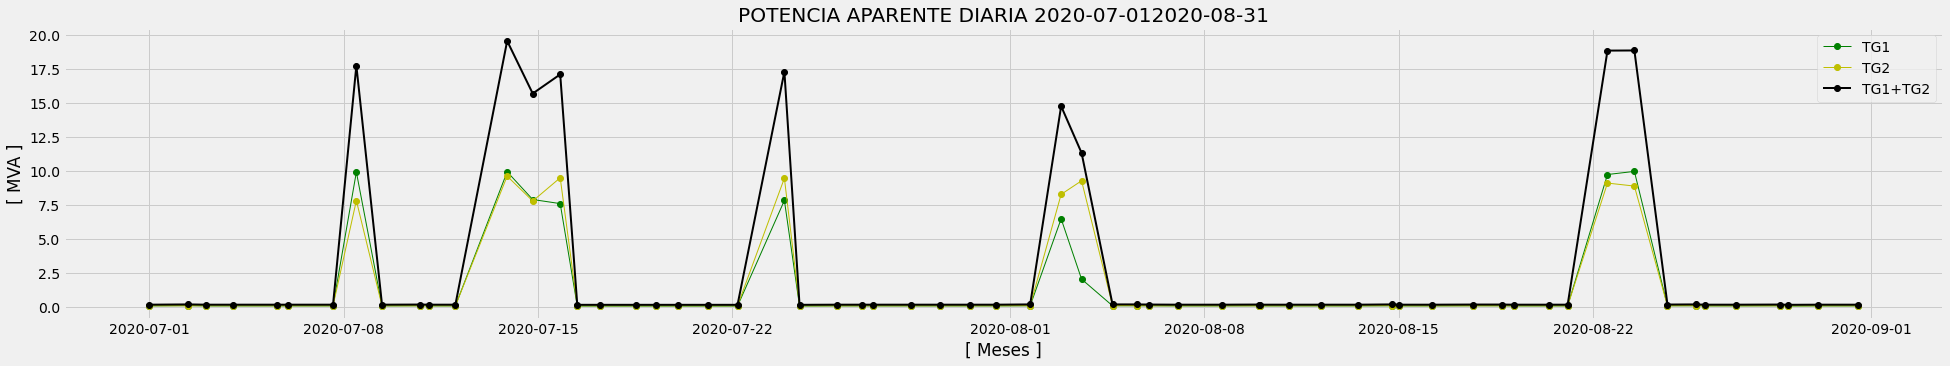

In [75]:
Grafica_xDia('2020-07-01', '2020-08-31')

<Figure size 432x288 with 0 Axes>

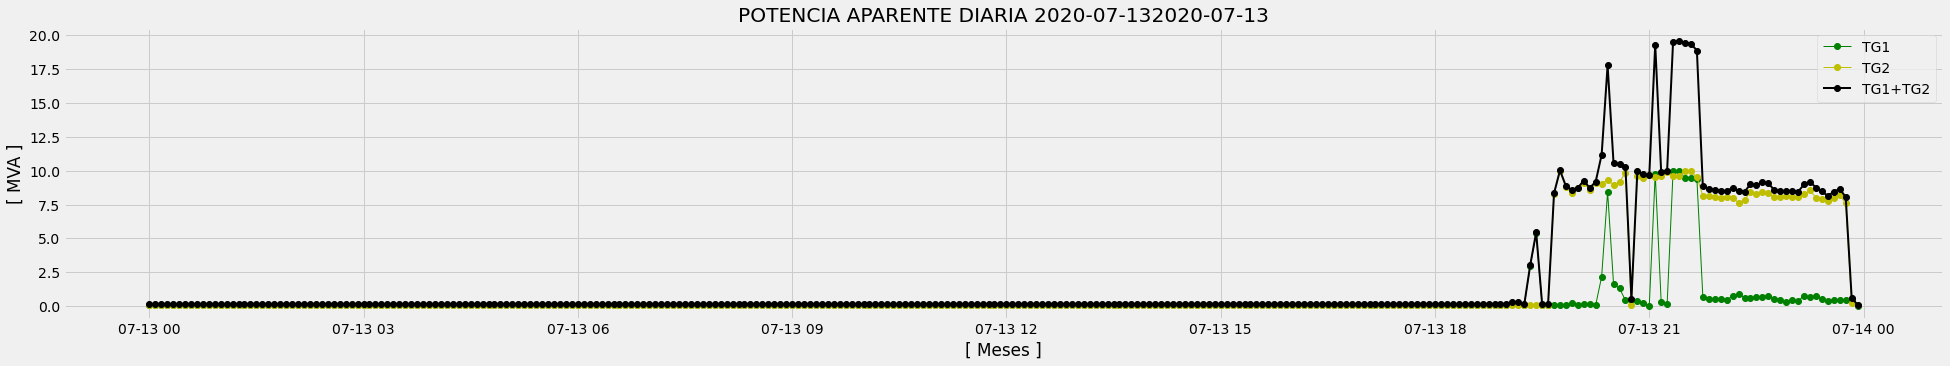

In [76]:
Grafica_xDia_Mensual('2020-07-13', '2020-07-13')

<Figure size 432x288 with 0 Axes>

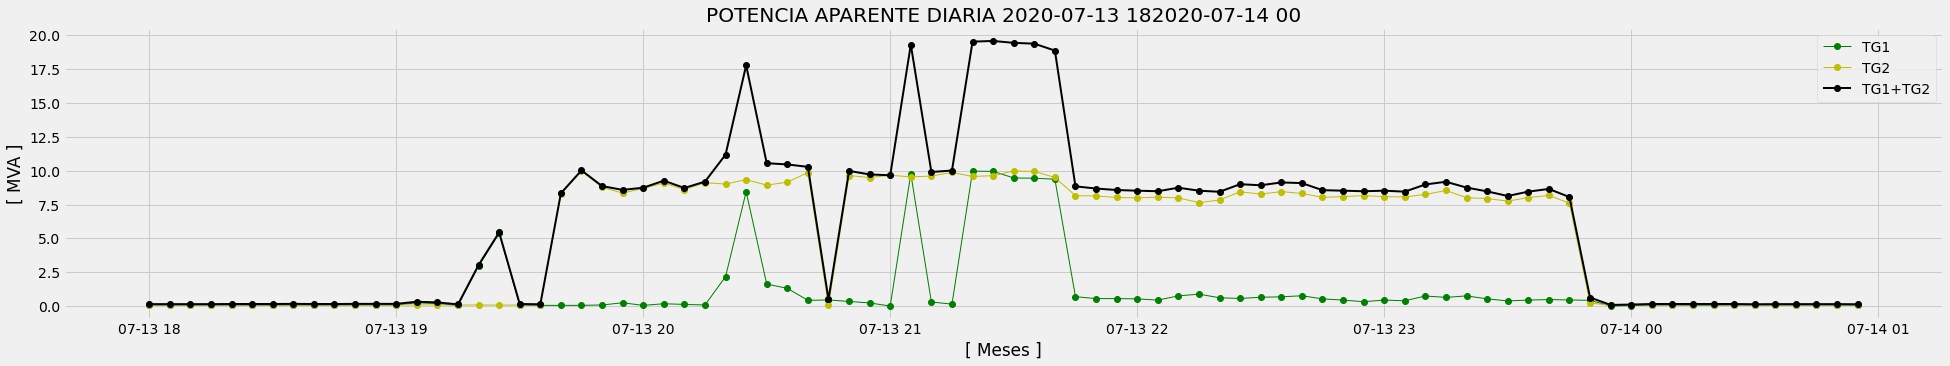

In [77]:
Grafica_xDia_Mensual('2020-07-13 18', '2020-07-14 00')

<Figure size 432x288 with 0 Axes>

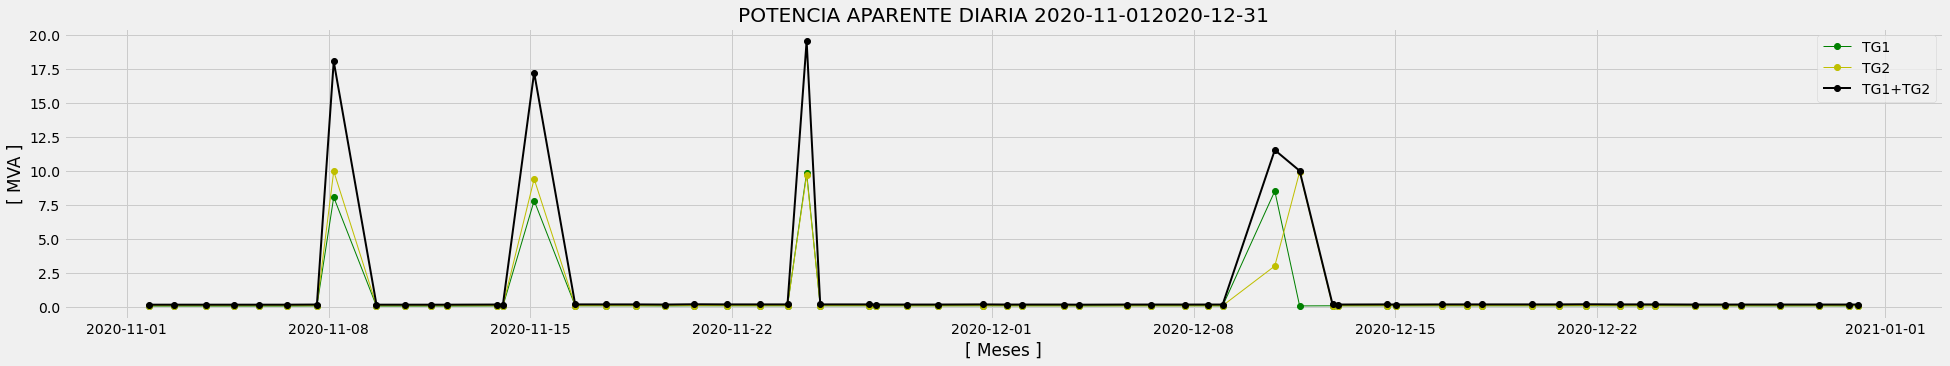

In [84]:
Grafica_xDia('2020-11-01', '2020-12-31')

<Figure size 432x288 with 0 Axes>

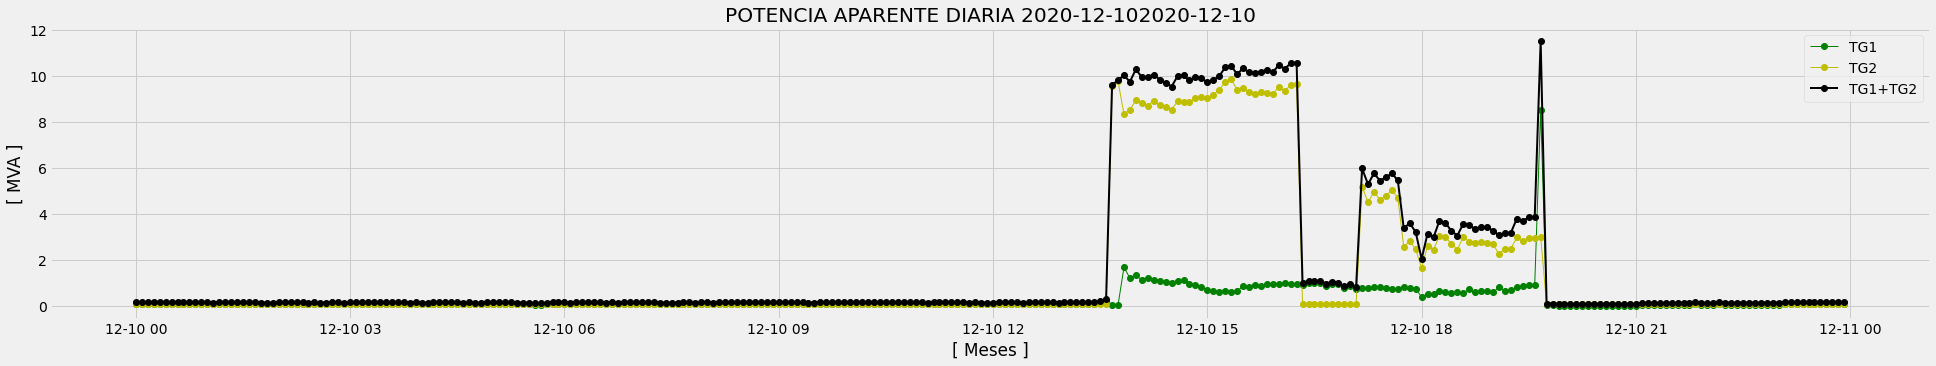

In [81]:
Grafica_xDia_Mensual('2020-12-10', '2020-12-10')

<Figure size 432x288 with 0 Axes>

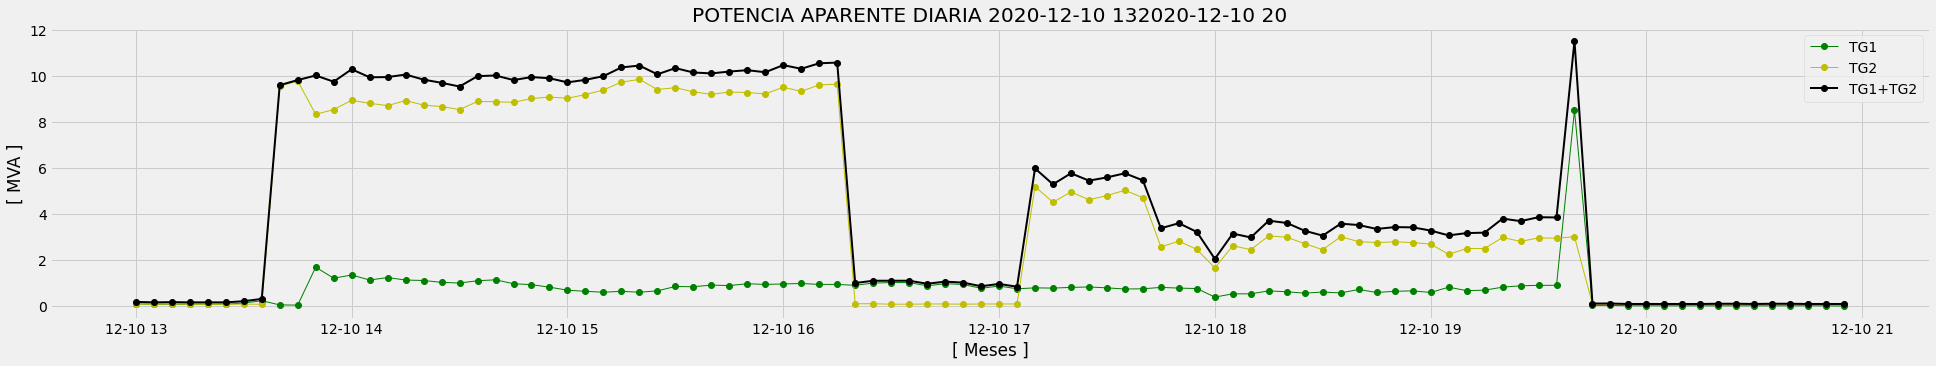

In [80]:
Grafica_xDia_Mensual('2020-12-10 13', '2020-12-10 20')

<Figure size 432x288 with 0 Axes>

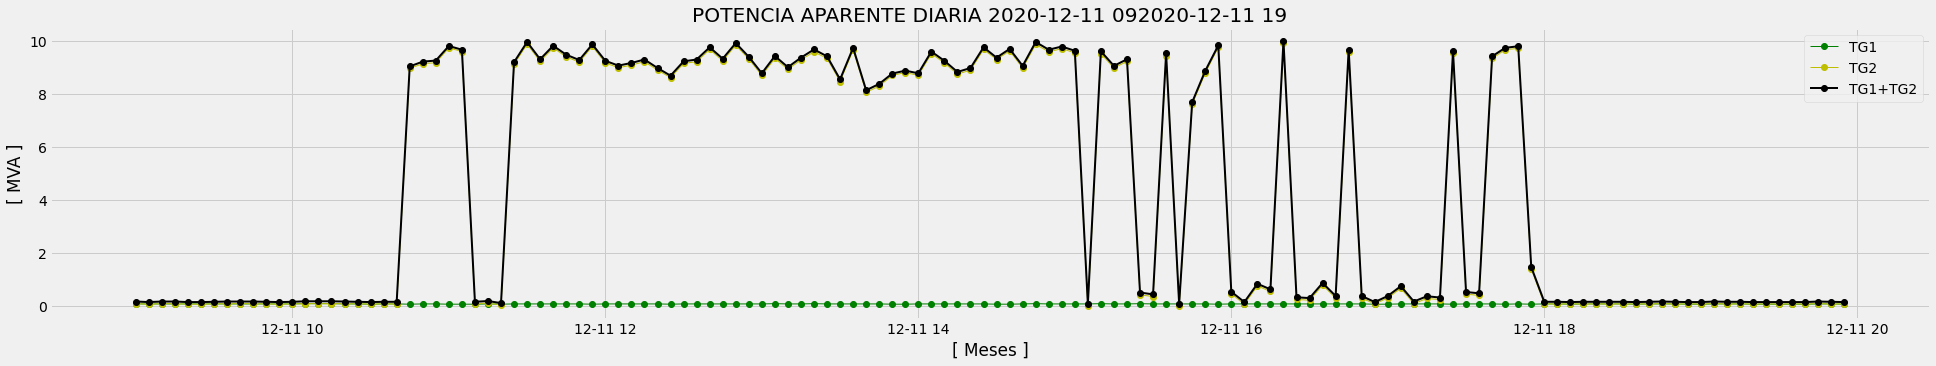

In [85]:
Grafica_xDia_Mensual('2020-12-11 09', '2020-12-11 19')

# Valores Maximos de Suma x Mes 
No tiene mucho sentido en Generadores pero puede servir para ver si estuvo Parada o en Mantenimiento

In [69]:
#
# Generar Pot_Max_xMes para todos los anios

# Obtengo los Valores Maximos x MES  ---- No puedo utilizar resample('D') porque me da los valores Maximos para todas las columnas
# y yo necesito los valores MVA para los cuales Suma es maxima en el MES

#anios = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']

Pot_max_xmes = pd.DataFrame(columns = ['TG1_MVA', 'TG2_MVA', 'Suma'])

anio_ini = '2011'
anio_fin = '2020'
pi = anio_ini + '-01-01'
pf = anio_fin + '-12-31'

meses = pd.date_range(start=pi, end=pf, freq='M')
for mes in meses:
    mes = mes.strftime('%Y/%m')
    if Gene.loc[mes, :].empty :
        pass
    else:
        ind = Gene.loc[mes, 'Suma'].idxmax()
        Pot_max_xmes.loc[ind] = Gene.loc[ind, ['TG1_MVA', 'TG2_MVA', 'Suma']] 

Pot_max_xmes.tail()

,TG1_MVA,TG2_MVA,Suma
2020-08-23 11:35:00,9.98,8.90,18.88
2020-09-12 18:35:00,0.07,9.37,9.44
2020-10-07 17:35:00,0.09,0.11,0.20
2020-11-24 13:55:00,9.85,9.68,19.53
2020-12-10 19:40:00,8.51,3.01,11.52


In [70]:
# Grafica del Pico Maximo Potencia Aparente x DIA

def Grafica_Pot_Max_xMes(pi, pf):
    plt.style.use('fivethirtyeight')
        
    TG1 = Pot_max_xmes.loc[pi:pf, 'TG1_MVA']
    TG2 = Pot_max_xmes.loc[pi:pf, 'TG2_MVA']
    
    Suma = Pot_max_xmes.loc[pi:pf, 'Suma']
    tiempo = TG1.index 
    
    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(30, 5))
    
    #grafico.plot(x, y, lw=1, label='Potencia Aparente', marker='o')
    grafico.plot(tiempo, TG1, lw=1, label='TD1', marker='o', color='g')
    grafico.plot(tiempo, TG2, lw=1, label='TD2', marker='o', color='y')
    
    grafico.plot(tiempo, Suma, lw=2, label='TG1+TG2', marker='o', color='k')
    
    grafico.set_xlabel('[ Meses ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("POTENCIA APARENTE DIARIA " + pi + pf)  # Add a title to the axes.
    grafico.legend()  # Add a legend.
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid()
    
    #fig.savefig("Serie_Anual_xDia_"+anio+".png")

<Figure size 432x288 with 0 Axes>

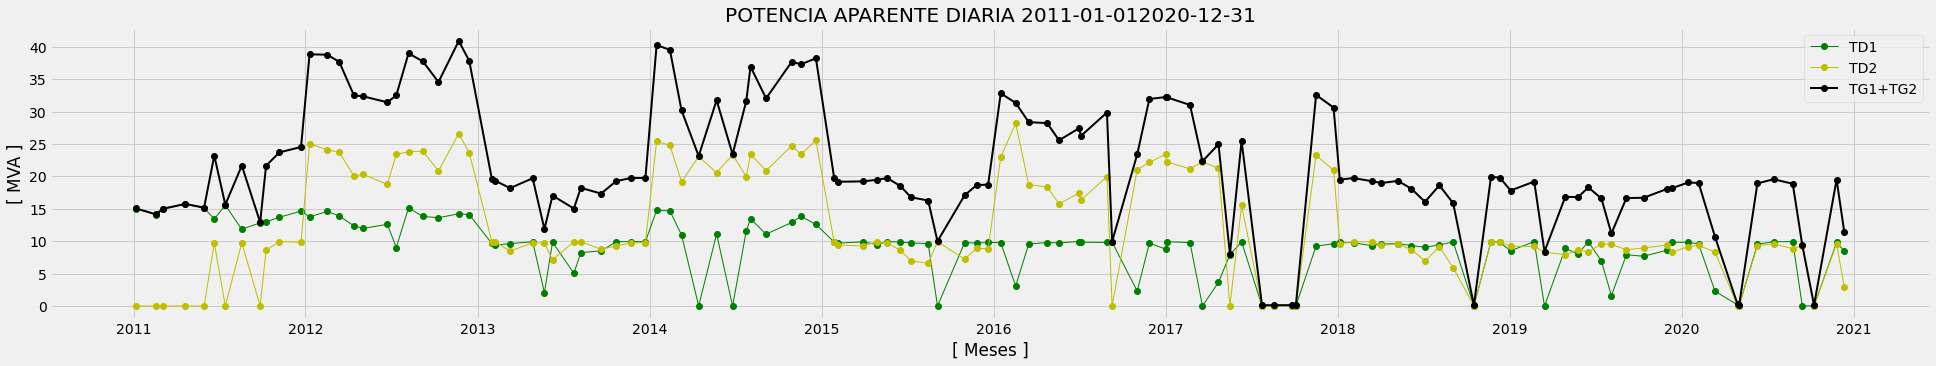

In [39]:
Grafica_Pot_Max_xMes('2011-01-01','2020-12-31')

<Figure size 432x288 with 0 Axes>

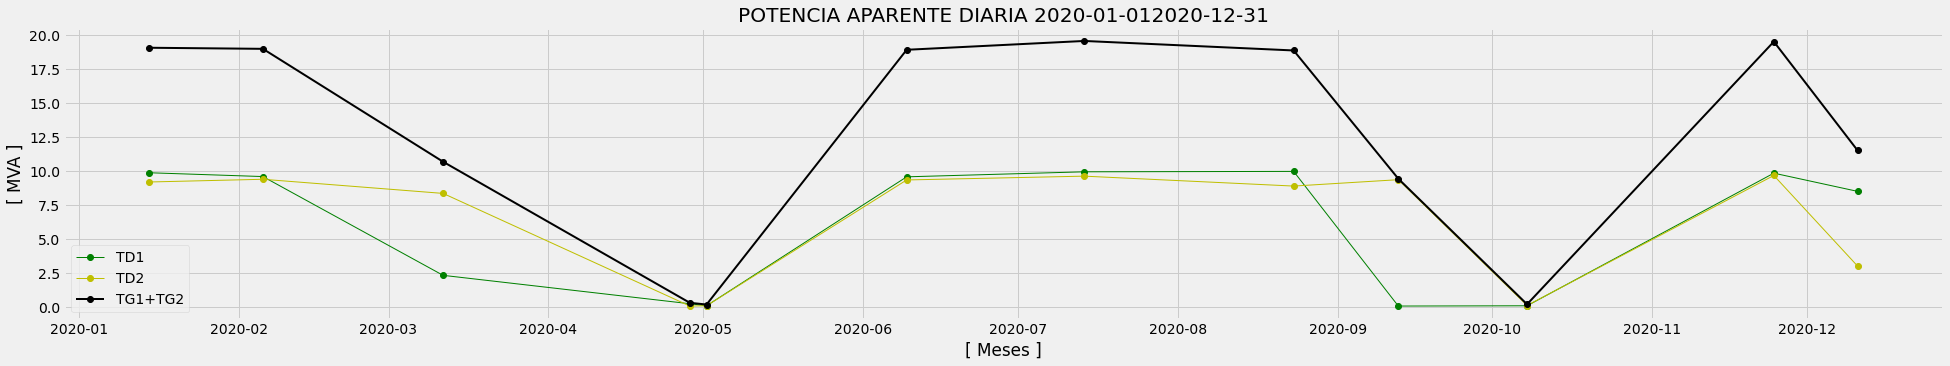

In [40]:
Grafica_Pot_Max_xMes('2020-01-01','2020-12-31')

# borradores

## Chequeo si hay Registros / Filas Faltantes
Si dife distinto de cero, significa que faltan registros/filas en los datos del SITEC

In [41]:
#pot5 = Pot_max_xdia.reindex(indice)

In [42]:
parar_corrida
pot2.index.format()
pot2.index.values
#pot2.index.is_all_dates()
if pot2.index.has_duplicates:
    print('SI TIENE DUPLI')
else:
    print('NO tiene')

NameError: name 'parar_corrida' is not defined

In [ ]:
Pot_max_xmes.head()

In [ ]:
if dife.empty == False:
    print('Faltan algunas Mediciones: ', len(dife), '% Incompletas= ', (len(dife)/len(indice)*100), '% Completas= ', \
          (((len(indice)-len(dife))/len(indice))*100))
else:
    print('Mediciones Completas: ', (((len(indice)-len(dife))/len(indice))*100))

In [ ]:
#datos2 = datos.drop(['Fecha', 'Hora'], axis=1)
#data.drop(['Fecha', 'Hora', 'Ampere', 'KVolt'], axis=1)
#datos2.iloc[0:100, :]

In [ ]:
TD1_atipicos

In [ ]:

#plt.boxplot(Trafos['TD1_MVA', 'TD2_MVA', 'TD3_MVA', 'Suma'])

data = TD1[['TD1_MVA']]
fig1, ax1 = plt.subplots()
ax1.set_title('TD1 Potencia Aparente")')
#plt.ylabel("TD1_MVA")
ax1.set_ylabel('TD1_MVA', fontsize=15)  # Add a y-label to the axes.
ax1.set_ylim([0,80])
ax1.boxplot(data)
plt.show()

In [ ]:
# Deteccion de Outliers

# BORRAMOS LOS ATIPICOS DEL TRAFO TD1

# if TD1_atipicos.empty == False:
#     indice = TD1_atipicos.index
#     TD1 = TD1.drop(indice)
#     print('Atipicos identificados: %d' % len(TD1_atipicos))
# else:
#     print('SIN Atipicos para borrar: %d' % len(TD1_atipicos))
    
    

In [ ]:
# CONCATENAR TD1 + TD2 + TD3
#
tr = pd.concat([TD1_sin_atipicos, TD2_sin_atipicos, TD3_sin_atipicos], axis = 1)
tr

In [ ]:
TD1_sin_atipicos.loc['2017-01', :]

In [ ]:
TD2_sin_atipicos.loc['2017-01-04', : ]

In [ ]:
TD3_sin_atipicos.loc['2017-01-04', : ]

In [ ]:
tr.loc['2017-01-27 09:25:00':'2017-01-27 09:30:00', :]

In [ ]:
tr.loc['2017-01-27 09:20:00':'2017-01-27 09:35:00', :]

In [ ]:
TD3_atipicos

In [ ]:
TD3_sin_atipicos.loc['2017-02-04 02:10:00':'2017-02-04 02:15:00', :]

In [ ]:
dia = '2014-03-18'
TD1.loc[dia, :]

In [ ]:
dia = '2014-03-18'
TD1.loc['2020-12-26 23':'2020-12-28 12', :]

In [ ]:
Trafos

In [ ]:
# CHEQUEA EL INDICE POR DIAS FALTANTES 
# SI FALTA UN DIA: AGREGA LA FILA CON VALORES NAN

ind_td1 = TD1_sin_atipicos.index
ind_td2 = TD2_sin_atipicos.index
 
dife = ind_td2.difference(ind_td1)
dife

In [ ]:
len(dife)

In [ ]:
ind_td1_2017 = TD1_sin_atipicos.loc['2017':'2020', :].index
ind_td3 = TD3_sin_atipicos.index
 
dife2 = ind_td3.difference(ind_td1_2017)
dife2

In [ ]:
145+53

In [ ]:
TD1_sin_atipicos.loc['2017':'2020', :]

In [ ]:
dife3 = dife.difference(ind_td3)
dife3

In [ ]:
len(dife3)

In [ ]:
Trafos.loc['2017-01-20 06:30:00':'2017-01-20 14:25:00' , :]

In [ ]:
Trafos.loc['2017-01-20 11:00:00':'2017-01-20 11:55:00' , :]

In [ ]:
TD3.loc['2017-01-20 06:30:00':'2017-01-20 14:25:00' , :]

In [ ]:
ind1 = TD1_sin_atipicos.loc['2017':'2020', :].index